<a href="https://colab.research.google.com/github/FredPedrosa/song_sent_scores/blob/main/song_sent_scores_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Imports, Device Setup, Warnings

"""
song_sent_scores_py.py

Python translation of song_sent_scores functions WITH MODEL CACHING.
Loads models (CLAP, ASR, NLI) only once per session and reuses them.
Designed for use in Google Colab environments.
"""

!pip install -q yt-dlp
!pip install resampy --quiet
import yt_dlp
import torch
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import gc
import time
import os
import re
from transformers import AutoProcessor, AutoModel, pipeline

# Optional for plot labels: pip install adjustText
try:
    from adjustText import adjust_text
    HAS_ADJUSTTEXT = True
except ImportError:
    HAS_ADJUSTTEXT = False


if torch.cuda.is_available():
    _device = torch.device("cuda:0")
    print(f"GPU detected. Using device: {torch.cuda.get_device_name(0)}")
else:
    _device = torch.device("cpu")
    print("GPU not detected. Using CPU.")

warnings.filterwarnings('ignore', message='.*Maximum duration.*')
warnings.filterwarnings('ignore', message='.*Using PipelineChunkIterator.*')
# ... (outras supressões de warning)


# ==========================================
# --- Global Dictionaries for Caching Models ---
# ==========================================
# Stores loaded models/processors/pipelines keyed by their Hugging Face ID
_loaded_clap_models = {}
_loaded_asr_pipelines = {}
_loaded_nli_pipelines = {}



GPU detected. Using device: Tesla T4


In [25]:
#@title Helper Functions

def _clear_gpu_cache():
    gc.collect()
    if _device.type == 'cuda':
        torch.cuda.empty_cache()

def _release_object(obj):
    obj = None

def _get_audio_segment(audio_fpath, target_sr, offset=None, duration=None, verbose=False):
    # (Código da função _get_audio_segment igual ao anterior)
    actual_duration = 0.0
    audio_array = None
    try:
        audio_array, sr_ = librosa.load(audio_fpath, sr=target_sr, mono=True, offset=offset, duration=duration, res_type='kaiser_fast')
        if not isinstance(audio_array, np.ndarray) or audio_array.size == 0 or np.max(np.abs(audio_array)) < 1e-6 :
             if verbose: print(f'  [AudioLoad] Warning: Loaded audio array empty/silent.')
             return None, 0.0
        actual_duration = librosa.get_duration(y=audio_array, sr=sr_)
        return audio_array.astype(np.float32), actual_duration
    except Exception as e:
        print(f'  [AudioLoad] Error loading audio {audio_fpath}: {e}')
        return None, 0.0

def normalize_scores_py(scores):
    # (Código da função normalize_scores_py igual ao anterior)
    if scores is None or len(scores) != 2: return [np.nan, np.nan]
    try:
        scores_arr = np.array(scores, dtype=float); scores_arr[np.isnan(scores_arr)] = 0 # Treat potential NaNs from model as 0? Or keep NaN? Let's try 0 for normalization.
        scores_arr[scores_arr < 0] = 0; total = np.sum(scores_arr)
        if total > 1e-9: return (scores_arr / total).tolist()
        else: return [0.5, 0.5] # Both zero or negative
    except Exception: return [np.nan, np.nan]


# =======================================
# --- Model Loading/Caching Functions ---
# =======================================

def _get_clap_model(model_ident, verbose=False):
    """Loads or retrieves cached CLAP model and processor."""
    if model_ident in _loaded_clap_models:
        if verbose: print(f"  Reusing cached CLAP model: {model_ident}")
        return _loaded_clap_models[model_ident]
    else:
        if verbose: print(f"  Loading CLAP model & processor: {model_ident}...")
        st = time.time()
        try:
            processor = AutoProcessor.from_pretrained(model_ident)
            model = AutoModel.from_pretrained(model_ident).to(_device)
            model.eval() # Set to evaluation mode
            _loaded_clap_models[model_ident] = {"processor": processor, "model": model}
            if verbose: print(f" CLAP Model {model_ident} loaded to {_device} in {time.time() - st:.2f}s.")
            return _loaded_clap_models[model_ident]
        except Exception as e:
            print(f"  Error loading CLAP model {model_ident}: {e}")
            # Don't cache on failure
            return None

def _get_asr_pipeline(model_ident, verbose=False):
    """Loads or retrieves cached ASR (Whisper) pipeline."""
    if model_ident in _loaded_asr_pipelines:
        if verbose: print(f"  Reusing cached ASR pipeline: {model_ident}")
        return _loaded_asr_pipelines[model_ident]
    else:
        if verbose: print(f"  Loading ASR pipeline: {model_ident}...")
        st = time.time()
        try:
            # Specify device during pipeline creation
            asr_pipe = pipeline('automatic-speech-recognition', model=model_ident, device=_device,
                                chunk_length_s=30, stride_length_s=5)
            _loaded_asr_pipelines[model_ident] = asr_pipe
            if verbose: print(f"  ASR Pipeline {model_ident} loaded to {_device} in {time.time() - st:.2f}s.")
            return asr_pipe
        except Exception as e:
            print(f"  Error loading ASR pipeline {model_ident}: {e}")
            return None

def _get_nli_pipeline(model_ident, verbose=False):
    """Loads or retrieves cached NLI (Zero-Shot) pipeline."""
    if model_ident in _loaded_nli_pipelines:
        if verbose: print(f" Reusing cached NLI pipeline: {model_ident}")
        return _loaded_nli_pipelines[model_ident]
    else:
        if verbose: print(f" Loading NLI pipeline: {model_ident}...")
        st = time.time()
        try:
            nli_pipe = pipeline('zero-shot-classification', model=model_ident, device=_device)
            _loaded_nli_pipelines[model_ident] = nli_pipe
            if verbose: print(f"  NLI Pipeline {model_ident} loaded to {_device} in {time.time() - st:.2f}s.")
            return nli_pipe
        except Exception as e:
            print(f"  Error loading NLI pipeline {model_ident}: {e}")
            return None


# =============================
# --- Core Analysis Helpers ---
# =============================

def get_clap_scores_pair_py(audio_fpath, class_pair, model_ident, offset=None, duration=None, verbose=False):
    """Gets CLAP scores using cached models."""
    # Get model from cache (or load it)
    clap_components = _get_clap_model(model_ident, verbose)
    if clap_components is None:
        return {'error': f'Failed to load/retrieve CLAP model: {model_ident}', 'scores': [], 'duration': 0.0}
    processor = clap_components["processor"]
    model = clap_components["model"]

    # --- Rest of the logic is similar, but NO model loading/deletion ---
    audio_array=None; inputs_dict = None; outputs = None;
    scores = []; error_msg = None; actual_dur = 0.0;
    func_st = time.time()
    try:
        sampling_rate = getattr(processor.feature_extractor, 'sampling_rate', 48000)
        if verbose: print(f'  [CLAP] Loading audio segment (SR={sampling_rate})...')
        audio_array, actual_dur = _get_audio_segment(audio_fpath, sampling_rate, offset, duration, verbose)

        if audio_array is None:
            error_msg = 'CLAP audio segment empty/load failed.'
            print(f"  [CLAP] Warning: {error_msg}")
            return {'error': error_msg, 'scores': [], 'duration': 0.0} # Return 0 duration

        if verbose: print(f'  [CLAP] Processing classes: {class_pair}')
        inputs_dict = processor(text=list(class_pair), audios=[audio_array], return_tensors='pt', padding=True, sampling_rate=sampling_rate)
        inputs_dict = {k: v.to(_device) for k, v in inputs_dict.items()}

        if verbose: print(f'  [CLAP] Running inference for {class_pair}...')
        infer_st=time.time();
        with torch.no_grad():
             outputs = model(**inputs_dict)
             logits_per_audio = outputs.logits_per_audio[0]
             probs = torch.softmax(logits_per_audio, dim=0).cpu().numpy()
             scores = probs.tolist()
        if verbose: print(f'  [CLAP] Inference OK ({time.time() - infer_st:.2f}s)')

    except Exception as e:
        error_msg = f'CLAP analysis failed for {class_pair}: {e}'
        scores = []
        print(f'  [CLAP] Error: {error_msg}')
    finally:
        # Release ONLY temporary tensors/arrays
        _release_object(inputs_dict)
        _release_object(outputs)
        _release_object(audio_array)
        _clear_gpu_cache() # Still clear GPU cache for tensors
        if verbose: print(f'  [CLAP] Task finished for {class_pair} (Duration: {time.time() - func_st:.2f}s)')

    return {'error': error_msg, 'scores': scores, 'duration': actual_dur} # Return actual duration


def transcribe_audio_py(audio_fpath, model_ident, offset=None, duration=None, language=None, verbose=False):
    """Transcribes using cached ASR pipeline."""
    # Get pipeline from cache (or load it)
    asr_pipe = _get_asr_pipeline(model_ident, verbose)
    if asr_pipe is None:
         return {'error': f'Failed to load/retrieve ASR pipeline: {model_ident}', 'text': None, 'duration': 0.0}

    # --- Rest of the logic is similar, but NO pipeline loading/deletion ---
    audio_array = None; transcription_result = None;
    txt = None; err = None; ad = 0.0;
    func_st = time.time()
    try:
        target_sr = getattr(asr_pipe.feature_extractor, 'sampling_rate', 16000)
        if verbose: print(f'  [ASR] Loading audio segment (SR={target_sr})...')
        audio_array, ad = _get_audio_segment(audio_fpath, target_sr, offset, duration, verbose)

        if audio_array is None:
            err = 'ASR audio segment empty/load failed.'
            print(f"  [ASR] Warning: {err}")
            return {'error': err, 'text': None, 'duration': 0.0}

        if verbose: print(f'  [ASR] Running transcription: {model_ident}...')
        generate_kwargs = {'return_timestamps': False} # Changed default to False
        if language:
            generate_kwargs['language'] = language
            if verbose: print(f'  [ASR] Language hint: {language}')

        infer_st = time.time()
        with torch.no_grad():
            transcription_result = asr_pipe(audio_array.copy(), generate_kwargs=generate_kwargs)
        if verbose: print(f'  [ASR] Transcription OK ({time.time() - infer_st:.2f}s)')

        txt = transcription_result['text'].strip() if transcription_result and 'text' in transcription_result else ''
        if not txt and verbose: print('  [ASR] Warning: Transcription resulted in empty text.')

    except Exception as e:
        err = f'ASR transcription failed: {e}'
        txt = None
        print(f'  [ASR] Error: {err}')
    finally:
        # Release ONLY temporary arrays/results
        _release_object(audio_array)
        _release_object(transcription_result)
        _clear_gpu_cache()
        if verbose: print(f'  [ASR] Task finished (Duration: {time.time() - func_st:.2f}s)')

    return {'error': err, 'text': txt, 'duration': ad}


def get_nli_scores_pair_py(text_input, class_pair, model_ident, verbose=False):
     """Gets NLI scores using pipeline."""
     # Get pipeline from cache (or load it)
     nli_pipe = _get_nli_pipeline(model_ident, verbose)
     if nli_pipe is None:
          return {'error': f'Failed to load/retrieve NLI pipeline: {model_ident}', 'scores': []}

     # --- Rest of the logic is similar, but NO pipeline loading/deletion ---
     scores=[]; err=None; nli_output=None;
     func_st = time.time()
     try:
         if not text_input or not isinstance(text_input, str) or len(text_input.strip()) < 3:
              err = 'NLI input text is invalid, empty, or too short.'
              if verbose: print(f'  [NLI] Warning: {err}')
              return {'error': err, 'scores': []}

         if verbose: print(f'  [NLI] Processing NLI for {class_pair}...')
         infer_st=time.time();
         with torch.no_grad():
              nli_output = nli_pipe(text_input, candidate_labels=list(class_pair), multi_label=False)
         if verbose: print(f'  [NLI] Inference OK ({time.time() - infer_st:.2f}s)')

         score_dict = {label: score for label, score in zip(nli_output['labels'], nli_output['scores'])}
         scores = [float(score_dict.get(label, 0.0)) for label in class_pair]

     except Exception as e:
         err = f'NLI analysis failed for {class_pair}: {e}'
         scores = []
         print(f'  [NLI] Error: {err}')
     finally:
         # Release ONLY temporary output
         _release_object(nli_output)
         _clear_gpu_cache()
         if verbose: print(f'  [NLI] Task finished for {class_pair} (Duration: {time.time() - func_st:.2f}s)')

     return {'error': err, 'scores': scores}


In [12]:
#@title song_sent_scores_py() and plot_circumplex_py()


def song_sent_scores_py(
    audio_path: str,
    lyrics: str = None,
    transcribe_audio: bool = False,
    start_sec: float = None,
    end_sec: float = None,
    clap_model_id: str = "laion/clap-htsat-unfused",
    nli_model_id: str = "joeddav/xlm-roberta-large-xnli",
    asr_model_id: str = "openai/whisper-base",
    asr_language: str = None,
    verbose: bool = True
    ):
    """
    Performs circumplex sentiment analysis (Valence/Arousal) on a song segment
    using Python (CLAP for audio, NLI/Zero-Shot for text).

    Returns:
        dict: (Return dictionary structure remains the same as before)
    """
    func_start_time = time.time()
    if verbose: print(f"\n--- Running song_sent_scores_py for: {os.path.basename(audio_path)} ---")

    # --- Fixed Classes ---
    valence_classes = ["negative valence", "positive valence"]
    arousal_classes = ["low arousal", "high arousal"]
    score_keys = ["neg_valence", "pos_valence", "low_arousal", "high_arousal"]

    # --- Initialize Results ---
    results = {
        "audio_scores": dict(zip(score_keys, [np.nan] * 4)),
        "text_scores": None,
        "valence_classes": valence_classes,
        "arousal_classes": arousal_classes,
        "transcribed_text": None,
        "text_source": "none",
        "models_used": {"clap": clap_model_id, "nli": None, "asr": None},
        "segment_info": {"start_sec": 0.0, "end_sec": None, "duration_analyzed_s": None}
    }

    # --- Validate Inputs & Segment ---
    if not os.path.exists(audio_path): print(f"Error: Audio file not found: {audio_path}"); return results
    offset = None; duration = None; segment_description = "the entire audio file"; user_defined_segment = False
    s_sec = start_sec if start_sec is not None else 0.0; e_sec = end_sec
    results["segment_info"]["start_sec"] = s_sec
    if e_sec is not None:
        user_defined_segment = True
        if not isinstance(s_sec,(int,float)) or s_sec<0: print("Error: 'start_sec' invalid."); return results
        if not isinstance(e_sec,(int,float)) or e_sec<=s_sec: print("Error: 'end_sec' invalid."); return results
        offset=float(s_sec); duration=float(e_sec-s_sec); results["segment_info"]["end_sec"]=e_sec
        results["segment_info"]["duration_analyzed_s"]=duration; segment_description=f"segment [{offset:.2f}s-{e_sec:.2f}s] (req_dur: {duration:.2f}s)"
    else: offset=float(s_sec); duration=None; segment_description=f"from {offset:.2f}s to end"
    if verbose: print(f"Analysis requested for {segment_description}")

    # --- Determine Actual Duration Early ---
    try:
        _, actual_duration_check = _get_audio_segment(audio_path, 8000, offset, duration, verbose=False)
        if actual_duration_check > 0:
             results["segment_info"]["duration_analyzed_s"] = actual_duration_check
             if not user_defined_segment: results["segment_info"]["end_sec"] = s_sec + actual_duration_check
             if verbose: print(f"Confirmed analysis segment duration: ~{actual_duration_check:.2f}s")
        elif user_defined_segment:
             if verbose: print(f"Warning: Could not confirm duration for requested segment. Proceeding.")
        else:
             if verbose: print(f"Warning: Could not determine audio duration from {offset:.2f}s.")
    except Exception as dur_e:
        if verbose: print(f"Warning: Could not pre-check segment duration ({dur_e}).")

    # --- 1. Audio Analysis (CLAP) ---
    if verbose: print(f"\n1. Initiating AUDIO analysis (CLAP: {clap_model_id})...")
    clap_analysis_start_time = time.time()
    audio_valence_raw = None; audio_arousal_raw = None; clap_success = False
    try:
        if verbose: print(" -> Analyzing Valence (Audio)...")
        clap_val_result = get_clap_scores_pair_py(audio_path, valence_classes, clap_model_id, offset, duration, verbose)
        if clap_val_result['error'] is None and len(clap_val_result['scores'])==2: audio_valence_raw = clap_val_result['scores']
        else: print(f"Warning: CLAP Valence failed - {clap_val_result['error']}")
        current_dur = results["segment_info"]["duration_analyzed_s"]; clap_dur = clap_val_result['duration']
        if clap_dur > 0: results["segment_info"]["duration_analyzed_s"] = max(current_dur if current_dur else 0.0, clap_dur)

        if verbose: print(" -> Analyzing Arousal (Audio)...")
        clap_aro_result = get_clap_scores_pair_py(audio_path, arousal_classes, clap_model_id, offset, duration, verbose)
        if clap_aro_result['error'] is None and len(clap_aro_result['scores'])==2: audio_arousal_raw = clap_aro_result['scores']
        else: print(f"Warning: CLAP Arousal failed - {clap_aro_result['error']}")
        current_dur = results["segment_info"]["duration_analyzed_s"]; clap_dur = clap_aro_result['duration']
        if clap_dur > 0: results["segment_info"]["duration_analyzed_s"] = max(current_dur if current_dur else 0.0, clap_dur)

        if audio_valence_raw is not None and audio_arousal_raw is not None:
            norm_val = normalize_scores_py(audio_valence_raw); norm_aro = normalize_scores_py(audio_arousal_raw)
            results["audio_scores"]["neg_valence"]=norm_val[0]; results["audio_scores"]["pos_valence"]=norm_val[1]
            results["audio_scores"]["low_arousal"]=norm_aro[0]; results["audio_scores"]["high_arousal"]=norm_aro[1]
            clap_success = True; print("Audio analysis completed.")
        else: print("Audio analysis incomplete due to CLAP errors.")
    except Exception as e: print(f"Error during overall Audio Analysis block: {e}")
    if verbose: print(f"Audio Analysis Duration: {time.time() - clap_analysis_start_time:.2f}s")

    # --- 2. Text Preparation / Transcription (ASR - Whisper) ---
    if verbose: print(f"\n2. Preparing Text for Analysis...")
    text_prep_start_time = time.time()
    text_to_analyze = None; perform_text_analysis_step = True
    if lyrics is not None:
        if transcribe_audio and verbose: print("Info: 'lyrics' provided, 'transcribe_audio=True' ignored.")
        if isinstance(lyrics, str) and len(lyrics.strip()) > 0:
             print("Using provided lyrics."); text_to_analyze = lyrics.strip(); results["text_source"] = "provided_lyrics"
        else:
             print("Warning: Provided 'lyrics' empty/invalid."); results["text_source"]="provided_lyrics_empty"; perform_text_analysis_step=False
    elif transcribe_audio:
        results["models_used"]["asr"] = asr_model_id # Record requested ASR model
        print(f"Initiating TRANSCRIPTION (ASR: {asr_model_id})...")
        try:
            asr_result = transcribe_audio_py(audio_path, asr_model_id, offset, duration, asr_language, verbose)
            if asr_result['error'] is None:
                results["transcribed_text"] = asr_result.get('text', '')
                current_dur = results["segment_info"]["duration_analyzed_s"]; asr_dur = asr_result['duration']
                if asr_dur > 0: results["segment_info"]["duration_analyzed_s"] = max(current_dur if current_dur else 0.0, asr_dur)
                if results["transcribed_text"] and len(results["transcribed_text"]) > 0:
                     preview = results['transcribed_text'][:100] + ('...' if len(results['transcribed_text']) > 100 else '')
                     print(f"Transcription OK ({len(results['transcribed_text'])} chars). Preview: '{preview}'")
                     text_to_analyze = results["transcribed_text"]; results["text_source"] = "transcribed"
                else:
                     print("Transcription completed but resulted in empty text."); results["text_source"]="transcribed_empty"; perform_text_analysis_step=False
            else:
                 print(f"Error: Transcription failed - {asr_result['error']}"); results["text_source"]="transcribed_failed"; perform_text_analysis_step=False
        except Exception as e:
            print(f"Error during Transcription block: {e}"); results["text_source"]="transcribed_failed"; perform_text_analysis_step=False
    else:
        if verbose: print("Skipping text analysis (no lyrics/transcription)."); results["text_source"]="none"; perform_text_analysis_step=False
    if verbose: print(f"Text Preparation Duration: {time.time() - text_prep_start_time:.2f}s")

    # --- 3. Text Analysis (NLI / Zero-Shot) ---
    if perform_text_analysis_step and text_to_analyze:
        results["models_used"]["nli"] = nli_model_id # Record requested NLI model
        print(f"\n3. Initiating TEXT analysis (NLI: {nli_model_id})...")
        nli_analysis_start_time = time.time()
        text_valence_raw = None; text_arousal_raw = None; nli_success = False
        try:
            if verbose: print(" -> Analyzing Valence (Text)...")
            nli_val_result = get_nli_scores_pair_py(text_to_analyze, valence_classes, nli_model_id, verbose)
            if nli_val_result['error'] is None and len(nli_val_result['scores'])==2: text_valence_raw = nli_val_result['scores']
            else: print(f"Warning: NLI Valence failed - {nli_val_result['error']}")

            if verbose: print(" -> Analyzing Arousal (Text)...")
            nli_aro_result = get_nli_scores_pair_py(text_to_analyze, arousal_classes, nli_model_id, verbose)
            if nli_aro_result['error'] is None and len(nli_aro_result['scores'])==2: text_arousal_raw = nli_aro_result['scores']
            else: print(f"Warning: NLI Arousal failed - {nli_aro_result['error']}")

            if text_valence_raw is not None and text_arousal_raw is not None:
                norm_val = normalize_scores_py(text_valence_raw); norm_aro = normalize_scores_py(text_arousal_raw)
                if results["text_scores"] is None: results["text_scores"] = dict(zip(score_keys, [np.nan]*4)) # Initialize if needed
                results["text_scores"]["neg_valence"]=norm_val[0]; results["text_scores"]["pos_valence"]=norm_val[1]
                results["text_scores"]["low_arousal"]=norm_aro[0]; results["text_scores"]["high_arousal"]=norm_aro[1]
                nli_success = True; print("Text analysis completed.")
            else: print("Text analysis incomplete due to NLI errors."); results["text_scores"] = None
        except Exception as e: print(f"Error during overall Text Analysis block: {e}"); results["text_scores"] = None
        if verbose: print(f"Text Analysis Duration: {time.time() - nli_analysis_start_time:.2f}s")
    elif results["text_source"] != "none":
         print("\n3. Text analysis skipped due to issues in preparation/transcription.")
         results["text_scores"] = None

    # --- Final Update & Return ---
    final_duration = results["segment_info"]["duration_analyzed_s"]
    results["segment_info"]["duration_analyzed_s"] = float(final_duration) if final_duration is not None else None
    final_end_sec = results["segment_info"]["end_sec"]
    results["segment_info"]["end_sec"] = float(final_end_sec) if final_end_sec is not None else None
    if verbose: print(f"\n--- song_sent_scores_py finished in {time.time() - func_start_time:.2f}s ---")
    return results


# ====================================================
# --- Plotting Function: plot_circumplex_scores_py ---
# ====================================================

def plot_circumplex_scores_py(results_sent: dict,
                              title: str = "Circumplex Model Scores",
                              point_size: int = 60,
                              label_points: bool = True):
    # (Code for plot_circumplex_scores_py is identical to the previous version)
    if not isinstance(results_sent, dict) or \
       (results_sent.get("audio_scores") is None and results_sent.get("text_scores") is None):
        print("Plot Warning: Input invalid or no scores."); return None
    plot_data = []; audio_scores = results_sent.get("audio_scores")
    if isinstance(audio_scores, dict) and len(audio_scores)==4 and not all(np.isnan(list(audio_scores.values()))):
        try:
            v_a=float(audio_scores["pos_valence"])-float(audio_scores["neg_valence"]); a_a=float(audio_scores["high_arousal"])-float(audio_scores["low_arousal"])
            if not (np.isnan(v_a) or np.isnan(a_a)): plot_data.append({"modality":"Audio","valence":v_a,"arousal":a_a})
            else: print("Plot Warning: Audio coords NaN.")
        except Exception as e: print(f"Plot Warning: Audio score processing error: {e}")
    text_scores = results_sent.get("text_scores")
    if isinstance(text_scores, dict) and len(text_scores)==4 and not all(np.isnan(list(text_scores.values()))):
        try:
            v_t=float(text_scores["pos_valence"])-float(text_scores["neg_valence"]); a_t=float(text_scores["high_arousal"])-float(text_scores["low_arousal"])
            if not (np.isnan(v_t) or np.isnan(a_t)): plot_data.append({"modality":"Text","valence":v_t,"arousal":a_t})
            else: print("Plot Warning: Text coords NaN.")
        except Exception as e: print(f"Plot Warning: Text score processing error: {e}")
    if not plot_data: print("Plot Warning: No valid coords to plot."); return None
    df = pd.DataFrame(plot_data); fig, ax = plt.subplots(figsize=(6, 6))
    colors = {"Audio": "#4c9a9e", "Text": "#b3bef2"}; markers = {"Audio": "o", "Text": "^"}; texts_for_adjust = []
    for modality in df['modality'].unique():
        md = df[df['modality'] == modality]
        ax.scatter(md['valence'], md['arousal'], color=colors.get(modality,"grey"), marker=markers.get(modality,"s"), s=point_size, label=modality, alpha=0.8, edgecolors='black', linewidth=0.5)
        if label_points:
            for i, row in md.iterrows(): texts_for_adjust.append(ax.text(row['valence'], row['arousal'], row['modality'], fontsize=9))
    ax.axhline(0, linestyle="--", color="grey", linewidth=0.8, zorder=0); ax.axvline(0, linestyle="--", color="grey", linewidth=0.8, zorder=0)
    ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1); ax.set_xticks(np.arange(-1, 1.1, 0.5)); ax.set_yticks(np.arange(-1, 1.1, 0.5))
    ax.set_xlabel("Valence (-Neg <-> +Pos)", fontsize=10); ax.set_ylabel("Arousal (-Low <-> +High)", fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold'); ax.grid(True, linestyle=':', linewidth=0.5, color='lightgrey'); ax.set_aspect('equal', adjustable='box')
    ax.legend(title="Modality", fontsize=9); caption = "Valence: -1 (Neg) to +1 (Pos)\nArousal: -1 (Low) to +1 (High)"
    ax.text(0.0, -0.2, caption, transform=ax.transAxes, ha='left', va='top', fontsize=8, color='grey')
    if label_points and texts_for_adjust:
        if HAS_ADJUSTTEXT:
            try: adjust_text(texts_for_adjust, ax=ax)
            except Exception as adj_e: print(f"Plot Warning: adjust_text failed: {adj_e}.")
        #else: print("Info: adjustText not available...") # Reduce noise
    plt.tight_layout(rect=[0, 0.05, 1, 0.95]); return fig


In [24]:
#@title Song download
url_da_musica = "https://www.youtube.com/watch?v=ZFhzHiZ28Yk"
!yt-dlp -x --audio-format mp3 -o "IdontKnow.mp3" "https://www.youtube.com/watch?v=ZFhzHiZ28Yk"

print("\nDownload e conversão (tentativa) concluídos.")
print("Verificando se o arquivo foi criado:")
!ls -lh IdontKnow.mp3

[youtube] Extracting URL: https://www.youtube.com/watch?v=ZFhzHiZ28Yk
[youtube] ZFhzHiZ28Yk: Downloading webpage
[youtube] ZFhzHiZ28Yk: Downloading tv client config
[youtube] ZFhzHiZ28Yk: Downloading player 14cfd4c0-main
[youtube] ZFhzHiZ28Yk: Downloading tv player API JSON
[youtube] ZFhzHiZ28Yk: Downloading ios player API JSON
[youtube] ZFhzHiZ28Yk: Downloading m3u8 information
[info] ZFhzHiZ28Yk: Downloading 1 format(s): 251
[download] Destination: IdontKnow.webm
[download] 100% of    3.41MiB in 00:00:00 at 9.25MiB/s
[ExtractAudio] Destination: IdontKnow.mp3
Deleting original file IdontKnow.webm (pass -k to keep)

Download e conversão (tentativa) concluídos.
Verificando se o arquivo foi criado:
-rw-r--r-- 1 root root 3.5M May  2  2024 IdontKnow.mp3



--- Running song_sent_scores_py Example ---
Using audio file: /content/IdontKnow.mp3


--- First Call (Segment 0-39s) ---

--- Running song_sent_scores_py for: IdontKnow.mp3 ---
Analysis requested for segment [0.00s-39.00s] (req_dur: 39.00s)
Confirmed analysis segment duration: ~39.00s

1. Initiating AUDIO analysis (CLAP: laion/clap-htsat-unfused)...
 -> Analyzing Valence (Audio)...
  Reusing cached CLAP model: laion/clap-htsat-unfused
  [CLAP] Loading audio segment (SR=48000)...
  [CLAP] Processing classes: ['negative valence', 'positive valence']
  [CLAP] Running inference for ['negative valence', 'positive valence']...
  [CLAP] Inference OK (0.06s)
  [CLAP] Task finished for ['negative valence', 'positive valence'] (Duration: 1.12s)
 -> Analyzing Arousal (Audio)...
  Reusing cached CLAP model: laion/clap-htsat-unfused
  [CLAP] Loading audio segment (SR=48000)...
  [CLAP] Processing classes: ['low arousal', 'high arousal']
  [CLAP] Running inference for ['low arousal', 'high arousal

/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


  [ASR] Transcription OK (4.02s)
  [ASR] Task finished (Duration: 5.52s)
Transcription OK (285 chars). Preview: 'I don't know what to do with myself, baby, since you've been gone. I don't know what to do with myse...'
Text Preparation Duration: 5.52s

3. Initiating TEXT analysis (NLI: joeddav/xlm-roberta-large-xnli)...
 -> Analyzing Valence (Text)...
 Reusing cached NLI pipeline: joeddav/xlm-roberta-large-xnli
  [NLI] Processing NLI for ['negative valence', 'positive valence']...
  [NLI] Inference OK (0.04s)
  [NLI] Task finished for ['negative valence', 'positive valence'] (Duration: 0.45s)
 -> Analyzing Arousal (Text)...
 Reusing cached NLI pipeline: joeddav/xlm-roberta-large-xnli
  [NLI] Processing NLI for ['low arousal', 'high arousal']...
  [NLI] Inference OK (0.04s)
  [NLI] Task finished for ['low arousal', 'high arousal'] (Duration: 0.44s)
Text analysis completed.
Text Analysis Duration: 0.89s

--- song_sent_scores_py finished in 9.51s ---
--- First Call Duration: 9.51s ---

---

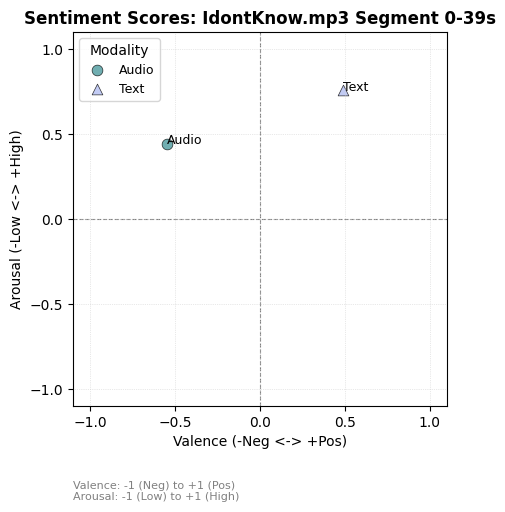



--- Second Call (Segment 40-96s) ---

--- Running song_sent_scores_py for: IdontKnow.mp3 ---
Analysis requested for segment [40.00s-96.00s] (req_dur: 56.00s)
Confirmed analysis segment duration: ~56.00s

1. Initiating AUDIO analysis (CLAP: laion/clap-htsat-unfused)...
 -> Analyzing Valence (Audio)...
  Reusing cached CLAP model: laion/clap-htsat-unfused
  [CLAP] Loading audio segment (SR=48000)...
  [CLAP] Processing classes: ['negative valence', 'positive valence']
  [CLAP] Running inference for ['negative valence', 'positive valence']...
  [CLAP] Inference OK (0.03s)
  [CLAP] Task finished for ['negative valence', 'positive valence'] (Duration: 0.60s)
 -> Analyzing Arousal (Audio)...
  Reusing cached CLAP model: laion/clap-htsat-unfused
  [CLAP] Loading audio segment (SR=48000)...
  [CLAP] Processing classes: ['low arousal', 'high arousal']
  [CLAP] Running inference for ['low arousal', 'high arousal']...
  [CLAP] Inference OK (0.03s)
  [CLAP] Task finished for ['low arousal', 'hig

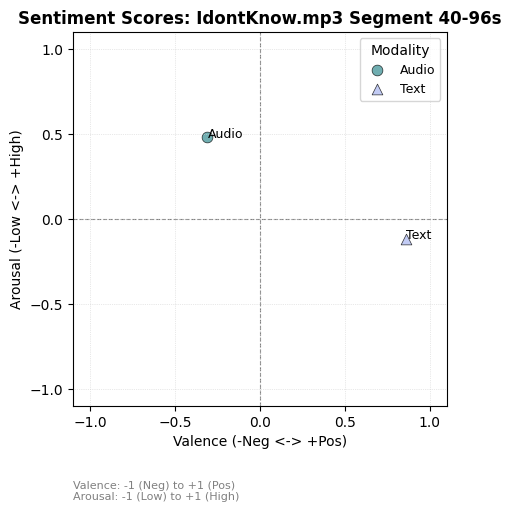


--- song_sent_scores_py Example Finished ---


In [26]:
#@title Example Usage Block

if __name__ == "__main__":
    print("\n--- Running song_sent_scores_py Example ---")

    # --- Configuration ---
    example_audio = "/content/IdontKnow.mp3" # Make sure this file exists

    # Checks if the file exists before proceeding
    if not os.path.exists(example_audio):
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        # ERROR: Audio file NOT FOUND at: {example_audio}
        print(f"ERROR dind't find the audio: {example_audio}")
        # Please upload the file to Colab and check the path.
        print(f"Please, upload the file to Colab and specify the right path.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        print(f"Using audio file: {example_audio}")

        # --- Define parameters (FIXED: Indentation removed) ---
        clap_m = "laion/clap-htsat-unfused"
        asr_m = "openai/whisper-large-v3" # Larger ASR model
        nli_m = "joeddav/xlm-roberta-large-xnli" # Multilingual NLI model

        # --- First Call (Models will be loaded) ---
        # Note: Segment times in the print/title below may differ from the code's start/end_sec
        print("\n\n--- First Call (Segment 0-39s) ---")
        start_call1 = time.time()
        results1 = song_sent_scores_py(
            audio_path=example_audio,
            lyrics=None, transcribe_audio=True,
            start_sec=0.00, end_sec=39.0,
            clap_model_id=clap_m, nli_model_id=nli_m, asr_model_id=asr_m,
            asr_language="en", # ADJUSTED: Assuming Portuguese (NOTE: Code uses 'en' here)
            verbose=True
        )
        print(f"--- First Call Duration: {time.time() - start_call1:.2f}s ---")

        # --- Show the Classification VALUES ---
        print("\n--- Classification Scores (First Call - results1) ---")
        print("Audio Scores:")
        if results1 and results1.get("audio_scores"):
             print(pd.Series(results1["audio_scores"]).to_string(float_format="%.4f"))
        else: print("N/A")
        print("\nText Scores:")
        if results1 and results1.get("text_scores"):
             print(pd.Series(results1["text_scores"]).to_string(float_format="%.4f"))
        else: print("N/A")
        print("\nTranscribed Text:")
        print(results1.get("transcribed_text", "N/A"))
        # --------------------------------------------

        print("\n--- Plotting Results (First Call) ---")
        # Adjust title if needed to reflect actual filename/segment
        figure1 = plot_circumplex_scores_py(results1, title="Sentiment Scores: IdontKnow.mp3 Segment 0-39s")
        if figure1:
             plt.show()

        # --- Second Call (Models should be reused from cache) ---
        # Note: Segment times in the print/title below may differ from the code's start/end_sec
        print("\n\n--- Second Call (Segment 40-96s) ---")
        start_call2 = time.time()
        results2 = song_sent_scores_py(
            audio_path=example_audio,
            lyrics=None, transcribe_audio=True,
            start_sec=40.0, end_sec=96.0,
            clap_model_id=clap_m, nli_model_id=nli_m, # Using same models
            asr_model_id=asr_m,
            asr_language="pt",
            verbose=True
        )
        print(f"--- Second Call Duration: {time.time() - start_call2:.2f}s ---")

        # --- Show the Classification VALUES ---
        print("\n--- Classification Scores (Second Call - results2) ---")
        print("Audio Scores:")
        if results2 and results2.get("audio_scores"):
             print(pd.Series(results2["audio_scores"]).to_string(float_format="%.4f"))
        else: print("N/A")
        print("\nText Scores:")
        if results2 and results2.get("text_scores"):
             print(pd.Series(results2["text_scores"]).to_string(float_format="%.4f"))
        else: print("N/A")
        print("\nTranscribed Text:")
        print(results2.get("transcribed_text", "N/A"))
        # --------------------------------------------

        # --- Plotting Example 2 ---
        print("\n--- Plotting Results (Second Call) ---") # Print title corrected
        # Adjust title if needed to reflect actual filename/segment
        figure2 = plot_circumplex_scores_py(results2, title="Sentiment Scores: IdontKnow.mp3 Segment 40-96s")
        if figure2:
             plt.show()




--- Running Local Loop Example ---
Using audio file: /content/IdontKnow.mp3
Processing in chunks of 15.0s...
Total song duration: 221.33s
Total chunks to process: 15

Processing Chunk 1/15 (0.00s - 15.00s)...
Audio analysis completed.
Initiating TRANSCRIPTION (ASR: openai/whisper-large-v3)...
Transcription OK (6 chars). Preview: 'Música'

3. Initiating TEXT analysis (NLI: joeddav/xlm-roberta-large-xnli)...
Text analysis completed.
Chunk 1 processed in 4.15s. Coords: a_v=-0.653, a_a=0.421, t_v=0.212, t_a=0.210

Processing Chunk 2/15 (15.00s - 30.00s)...
Audio analysis completed.
Initiating TRANSCRIPTION (ASR: openai/whisper-large-v3)...
Transcription OK (6 chars). Preview: 'Música'

3. Initiating TEXT analysis (NLI: joeddav/xlm-roberta-large-xnli)...
Text analysis completed.
Chunk 2 processed in 3.67s. Coords: a_v=-0.484, a_a=0.412, t_v=0.212, t_a=0.210

Processing Chunk 3/15 (30.00s - 45.00s)...
Audio analysis completed.
Initiating TRANSCRIPTION (ASR: openai/whisper-large-v3)...
Trans

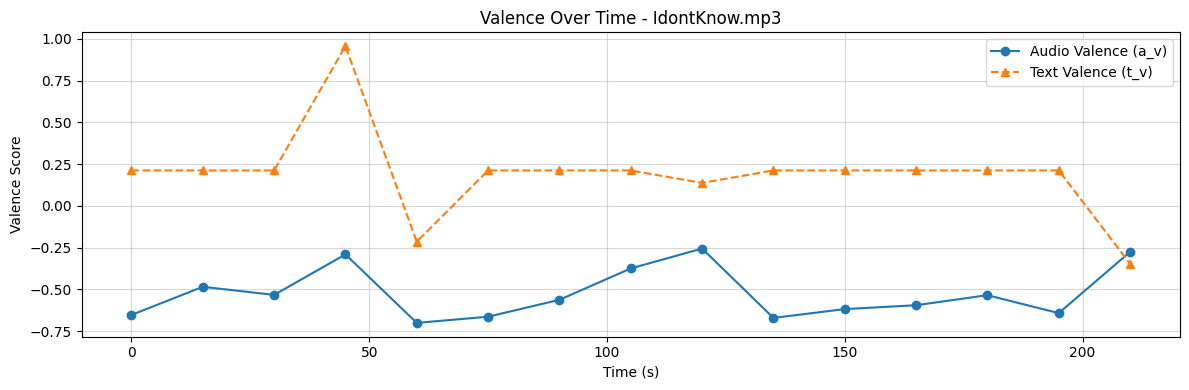


--- Raw results from first chunk ---
{'audio_scores': {'neg_valence': 0.8263773218618227, 'pos_valence': 0.17362267813817728, 'low_arousal': 0.2894887328147888, 'high_arousal': 0.7105112671852112}, 'text_scores': {'neg_valence': 0.39384613073789293, 'pos_valence': 0.606153869262107, 'low_arousal': 0.3950992642372627, 'high_arousal': 0.6049007357627373}, 'valence_classes': ['negative valence', 'positive valence'], 'arousal_classes': ['low arousal', 'high arousal'], 'transcribed_text': 'Música', 'text_source': 'transcribed', 'models_used': {'clap': 'laion/clap-htsat-unfused', 'nli': 'joeddav/xlm-roberta-large-xnli', 'asr': 'openai/whisper-large-v3'}, 'segment_info': {'start_sec': 0.0, 'end_sec': 15.0, 'duration_analyzed_s': 15.0}}


In [27]:
#@title Example Usage Block with Local Loop

if __name__ == "__main__":
    print("\n--- Running Local Loop Example ---")

    # --- Configuration ---
    audio_path = "/content/IdontKnow.mp3"
    chunk_duration_s = 15.0
    # Model IDs
    clap_m = "laion/clap-htsat-unfused"
    asr_m = "openai/whisper-large-v3" # Or 'whisper-base' etc.
    nli_m = "joeddav/xlm-roberta-large-xnli"
    asr_lang = "pt" # Set language or None for auto-detect

    # --- Check if the file exists ---
    if not os.path.exists(audio_path):
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        # ERROR: Audio file NOT FOUND at: {audio_path}
        print(f"ERRO: didn't finde the file at {audio_path}")
        # Please upload the file to Colab and check the path.
        print(f"Please, upload the file to Colab and verify the path.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        print(f"Using audio file: {audio_path}")
        print(f"Processing in chunks of {chunk_duration_s}s...")

        # --- Get total duration ---
        try:
            total_duration = librosa.get_duration(path=audio_path)
            if total_duration is None or total_duration <= 0:
                 raise ValueError("Could not get valid duration")
            print(f"Total song duration: {total_duration:.2f}s")
        except Exception as e:
            print(f"Error getting duration: {e}. Aborting loop.")
            total_duration = 0 # To avoid error in chunk calculation

        # --- List to store results from each chunk ---
        list_of_chunk_results_raw = [] # Stores the complete dictionaries
        list_of_calculated_coords = [] # Stores only the calculated coords

        # --- Calculate number of chunks and start loop ---
        if total_duration > 0:
            num_chunks = math.ceil(total_duration / chunk_duration_s)
            print(f"Total chunks to process: {num_chunks}")
            start_loop_time = time.time()

            for i in range(num_chunks):
                chunk_start_process_time = time.time()
                start_sec = i * chunk_duration_s
                end_sec = min((i + 1) * chunk_duration_s, total_duration)
                current_chunk_duration = end_sec - start_sec

                # Avoid very short chunks at the end
                if current_chunk_duration < 1.0 and i == num_chunks -1:
                    print(f"\nSkipping last chunk {i+1}/{num_chunks} (duration {current_chunk_duration:.2f}s < 1.0s)")
                    continue

                print(f"\nProcessing Chunk {i+1}/{num_chunks} ({start_sec:.2f}s - {end_sec:.2f}s)...")

                # --- Call the analysis function for the chunk ---
                # Use verbose=False here to avoid cluttering the output
                results_chunk = song_sent_scores_py(
                    audio_path=audio_path,
                    lyrics=None, transcribe_audio=True,
                    start_sec=start_sec, end_sec=end_sec,
                    clap_model_id=clap_m, nli_model_id=nli_m, asr_model_id=asr_m,
                    asr_language=asr_lang,
                    verbose=False # Keep False for cleaner logs in the loop
                )

                # --- Store the raw result ---
                list_of_chunk_results_raw.append(results_chunk)

                # --- Calculate and store coordinates a_v, a_a, t_v, t_a ---
                a_v, a_a, t_v, t_a = np.nan, np.nan, np.nan, np.nan
                transcribed_text_chunk = results_chunk.get("transcribed_text")

                audio_scores = results_chunk.get("audio_scores")
                if isinstance(audio_scores, dict) and not all(np.isnan(list(audio_scores.values()))):
                    try:
                        a_v = float(audio_scores["pos_valence"]) - float(audio_scores["neg_valence"])
                        a_a = float(audio_scores["high_arousal"]) - float(audio_scores["low_arousal"])
                    except Exception: pass # Silently ignore calculation error here

                text_scores = results_chunk.get("text_scores")
                if isinstance(text_scores, dict) and not all(np.isnan(list(text_scores.values()))):
                    try:
                        t_v = float(text_scores["pos_valence"]) - float(text_scores["neg_valence"])
                        t_a = float(text_scores["high_arousal"]) - float(text_scores["low_arousal"])
                    except Exception: pass # Ignore calculation error

                list_of_calculated_coords.append({
                    "chunk_index": i,
                    "start_sec": start_sec,
                    "end_sec": end_sec,
                    "a_v": a_v, "a_a": a_a,
                    "t_v": t_v, "t_a": t_a,
                    "transcribed_text": transcribed_text_chunk
                })
                #---------------------------------------------------------
                chunk_end_process_time = time.time()
                print(f"Chunk {i+1} processed in {chunk_end_process_time - chunk_start_process_time:.2f}s. Coords: a_v={a_v:.3f}, a_a={a_a:.3f}, t_v={t_v:.3f}, t_a={t_a:.3f}")


            print(f"\n--- Loop Finished in {time.time() - start_loop_time:.2f}s ---")

            # --- Create DataFrame with calculated coordinates ---
            if list_of_calculated_coords:
                 circumplex_df = pd.DataFrame(list_of_calculated_coords)
                 print("\n--- DataFrame with Calculated Coordinates (Full) ---")
                 print(circumplex_df.to_string()) # Print the entire DataFrame

                 # --- Plot example using the DataFrame ---
                 try:
                    plt.figure(figsize=(12, 4))
                    plt.plot(circumplex_df['start_sec'], circumplex_df['a_v'], marker='o', linestyle='-', label='Audio Valence (a_v)')
                    plt.plot(circumplex_df['start_sec'], circumplex_df['t_v'], marker='^', linestyle='--', label='Text Valence (t_v)')
                    plt.xlabel("Time (s)")
                    plt.ylabel("Valence Score")
                    plt.title(f"Valence Over Time - {os.path.basename(audio_path)}")
                    plt.legend()
                    plt.grid(True, alpha=0.5)
                    plt.tight_layout()
                    plt.show()
                 except Exception as plot_e:
                     print(f"Could not generate example plot: {plot_e}")

            else:
                 print("\nNo valid coordinates were calculated.")

            # You also have the list 'list_of_chunk_results_raw' with the complete dictionaries
            print("\n--- Raw results from first chunk ---")
            if list_of_chunk_results_raw:
               print(list_of_chunk_results_raw[0])